# Exploring Data Exercises

Answer the questions below by using a combination of the techniques discussed in the lesson that you think is appropriate.

- How many different cases are there, by department?
- Does the percentage of cases that are late vary by department?
- On average, how late are the late cases by department?
- What is the service type that is the most late? Just for Parks & Rec?
- For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.
- Does whether or not its a weekend matter for when a case is opened/closed?
- On average, how many cases are opened a day for the Customer Service department?
- Does the number of service requests for the solid waste department vary by day of the week?

In [1]:
import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_311

spark = pyspark.sql.SparkSession.builder.getOrCreate()

df = wrangle_311(spark)
print("\ndf shape: (%d, %d)\n" % (df.count(), len(df.columns)))
df.show(1, vertical=True)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments

df shape: (841704, 20)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                

In [2]:
#How many cases are there by department?

cases_by_dept = df.groupBy("department").count().toPandas()

In [3]:
cases_by_dept

,department,count
0,Solid Waste,279270
1,Animal Care Services,116915
2,Trans & Cap Improvements,96193
3,Parks & Recreation,19907
4,Customer Service,2849
5,Metro Health,5163
6,City Council,33
7,DSD/Code Enforcement,321374


In [12]:
#Does the percentage of cases that are late vary by department?
nrows = df.count()
# Does number of days late depend on department?
(   
    df.filter('case_late')
    .groupby('department')
    .agg(mean('num_days_late').alias('days_late'), count('num_days_late').alias('n_cases_late'))
    .sort('days_late')
    .withColumn('days_late', round(col('days_late'), 1))
    .withColumn('percentage', col('n_cases_late') / nrows)
    .show(truncate=False)
)

+------------------------+---------+------------+--------------------+
|department              |days_late|n_cases_late|percentage          |
+------------------------+---------+------------+--------------------+
|Metro Health            |6.5      |829         |9.849068080940568E-4|
|Solid Waste             |7.2      |32945       |0.03914083810935911 |
|Trans & Cap Improvements|10.6     |5411        |0.006428625740165189|
|Parks & Recreation      |22.3     |3797        |0.00451108703297121 |
|Animal Care Services    |23.5     |23276       |0.02765342685789779 |
|DSD/Code Enforcement    |49.4     |26235       |0.031168914487753413|
|Customer Service        |87.7     |2010        |0.002388012888141199|
+------------------------+---------+------------+--------------------+



In [13]:
df.groupby("case_status").count().withColumn('percentage', col('count') / nrows).show()

+-----------+------+--------------------+
|case_status| count|          percentage|
+-----------+------+--------------------+
|       Open| 18110|0.021515877315540857|
|     Closed|823594|  0.9784841226844592|
+-----------+------+--------------------+



In [14]:
#On average, how late are the late cases by department?

# See above

In [17]:
# What is the service type that is the most late? Just for Parks & Rec?

(   
    df.filter('case_late')
    .groupby('service_request_type')
    .agg(mean('num_days_late').alias('days_late'), count('num_days_late').alias('n_cases_late'))
    .sort('days_late',ascending=False)
    .withColumn('days_late', round(col('days_late'), 1))
    .show(truncate=False)
)

+----------------------------------------+---------+------------+
|service_request_type                    |days_late|n_cases_late|
+----------------------------------------+---------+------------+
|Zoning: Recycle Yard                    |210.9    |132         |
|Zoning: Junk Yards                      |200.2    |262         |
|Structure/Housing Maintenance           |190.2    |51          |
|Donation Container Enforcement          |171.1    |122         |
|Storage of Used Mattress                |164.0    |7           |
|Labeling for Used Mattress              |162.4    |7           |
|Record Keeping of Used Mattresses       |154.0    |7           |
|Signage Requied for Sale of Used Mattr  |151.6    |12          |
|Traffic Signal Graffiti                 |137.6    |2           |
|License Requied Used Mattress Sales     |128.8    |7           |
|Curbstoning                             |120.4    |123         |
|Vendors                                 |117.7    |131         |
|CPS Energ

In [21]:
# Just for Parks & Rec?

(   
    df.filter('case_late')
    .filter(expr('department == "Parks & Recreation"'))
    .groupby('service_request_type')
    .agg(mean('num_days_late').alias('days_late'), count('num_days_late').alias('n_cases_late'))
    .sort('days_late',ascending=False)
    .withColumn('days_late', round(col('days_late'), 1))
    .show(truncate=False)
)

+-------------------------------------+---------+------------+
|service_request_type                 |days_late|n_cases_late|
+-------------------------------------+---------+------------+
|Amenity Park Improvement             |76.9     |25          |
|Major Park Improvement Install       |75.8     |17          |
|Reservation Assistance               |66.0     |2           |
|Park Building Maint Invest           |59.4     |23          |
|Sportfield Lighting                  |51.5     |268         |
|Electrical                           |43.0     |481         |
|Tree Removal                         |40.3     |84          |
|Landscape Maintenance                |38.9     |19          |
|Heavy Equipment                      |38.6     |19          |
|Miscellaneous Park Equipment         |33.6     |43          |
|Tree Trimming/Maintenance            |30.7     |171         |
|General Building Maintenance         |28.2     |105         |
|Masonry                              |28.0     |128   

In [28]:
#  For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

(   
    df.filter(expr('department == "DSD/Code Enforcement"'))
    .groupby('department','service_request_type')
    .count()
    .sort('count',ascending=False)
    .show(truncate=False)
)


+--------------------+--------------------------------------+-----+
|department          |service_request_type                  |count|
+--------------------+--------------------------------------+-----+
|DSD/Code Enforcement|Overgrown Yard/Trash                  |65895|
|DSD/Code Enforcement|Bandit Signs                          |32910|
|DSD/Code Enforcement|Front Or Side Yard Parking            |28794|
|DSD/Code Enforcement|Junk Vehicle On Private Property      |21473|
|DSD/Code Enforcement|Alley-Way Maintenance                 |20214|
|DSD/Code Enforcement|Right Of Way/Sidewalk Obstruction     |17699|
|DSD/Code Enforcement|Vacant Lot/Overgrown/Trash            |9329 |
|DSD/Code Enforcement|Minimum Housing-Owner Occupied        |8543 |
|DSD/Code Enforcement|Graffiti: Private Property (Corridors)|8525 |
|DSD/Code Enforcement|Dang. Premises/CL/SEC                 |8004 |
|DSD/Code Enforcement|Minimum Housing-Tenant Occupied       |7984 |
|DSD/Code Enforcement|"Vacant Lot-Private (12"")

In [27]:
#Look at other departments

(   
    df.groupby('department','service_request_type')
    .count()
    .sort('count',ascending=False)
    .show(truncate=False)
)

+------------------------+---------------------------------+-----+
|department              |service_request_type             |count|
+------------------------+---------------------------------+-----+
|Solid Waste             |No Pickup                        |86855|
|DSD/Code Enforcement    |Overgrown Yard/Trash             |65895|
|DSD/Code Enforcement    |Bandit Signs                     |32910|
|Solid Waste             |Damaged Cart                     |30338|
|DSD/Code Enforcement    |Front Or Side Yard Parking       |28794|
|Animal Care Services    |Stray Animal                     |26760|
|Animal Care Services    |Aggressive Animal(Non-Critical)  |24882|
|Solid Waste             |Cart Exchange Request            |22024|
|DSD/Code Enforcement    |Junk Vehicle On Private Property |21473|
|Trans & Cap Improvements|Pot Hole Repair                  |20616|
|DSD/Code Enforcement    |Alley-Way Maintenance            |20214|
|Solid Waste             |Lost/Stolen Cart                 |18

In [29]:
# Does whether or not its a weekend matter for when a case is opened/closed?

cases_by_day = df.select(
    "department",
    date_format("case_opened_date", "yyyy-MM-dd").alias("case_opened_date"),
    date_format("case_closed_date", "yyyy-MM-dd").alias("case_closed_date"),
)

cases_by_day.show(5, truncate=False)

+------------------------+----------------+----------------+
|department              |case_opened_date|case_closed_date|
+------------------------+----------------+----------------+
|Animal Care Services    |2018-01-01      |2018-01-01      |
|Trans & Cap Improvements|2018-01-01      |2018-01-03      |
|Trans & Cap Improvements|2018-01-01      |2018-01-02      |
|DSD/Code Enforcement    |2018-01-01      |2018-01-02      |
|Animal Care Services    |2018-01-01      |2018-01-01      |
+------------------------+----------------+----------------+
only showing top 5 rows



In [30]:
cases_opened_by_day = (
    cases_by_day
    .groupby('case_opened_date')
    .count()
    .na.drop()
    .sort('case_opened_date')
    .toPandas()
    .assign(case_opened_date=lambda df: pd.to_datetime(df.case_opened_date))
    .set_index('case_opened_date')
    ['count']
)
cases_opened_by_day.name = 'cases_opened'
cases_opened_by_day

case_opened_date
2017-01-01     155
2017-01-02    1397
2017-01-03    1760
2017-01-04    1613
2017-01-05    1791
              ... 
2018-08-04     665
2018-08-05     319
2018-08-06    2071
2018-08-07    2405
2018-08-08     604
Name: cases_opened, Length: 585, dtype: int64

In [31]:
cases_closed_by_day = (
    cases_by_day
    .groupby('case_closed_date')
    .count()
    .na.drop()
    .sort('case_closed_date')
    .toPandas()
    .assign(case_closed_date=lambda df: pd.to_datetime(df.case_closed_date))
    .set_index('case_closed_date')
    ['count']
)
cases_closed_by_day.name = 'cases_closed'

In [32]:
ts = pd.concat([cases_opened_by_day, cases_closed_by_day], axis=1)
ts

,cases_opened,cases_closed
2017-01-01,155,67
2017-01-02,1397,385
2017-01-03,1760,734
2017-01-04,1613,1206
2017-01-05,1791,1173
...,...,...
2018-08-04,665,730
2018-08-05,319,197
2018-08-06,2071,1713
2018-08-07,2405,2096


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, '0-Sun'),
  Text(1, 0, '1-Mon'),
  Text(2, 0, '2-Tue'),
  Text(3, 0, '3-Wed'),
  Text(4, 0, '4-Thu'),
  Text(5, 0, '5-Fri'),
  Text(6, 0, '6-Sat')])

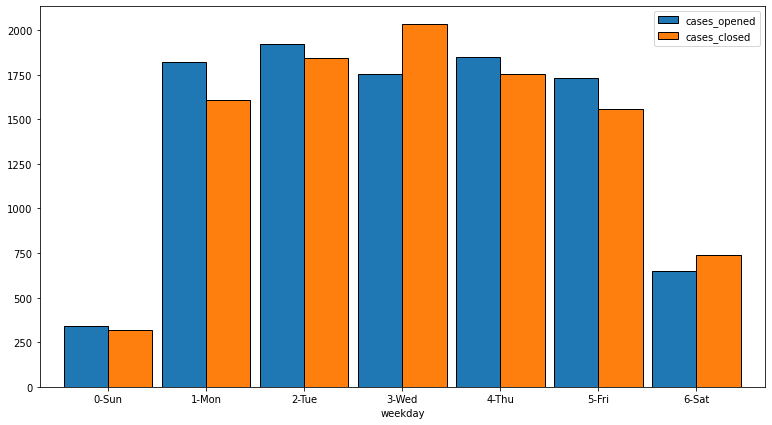

In [33]:
ts['weekday'] = ts.index.strftime('%w-%a')
ts.groupby('weekday').mean().plot.bar(figsize=(13, 7), ec='black', width=.9)
plt.xticks(rotation=0)

In [36]:
# On average, how many cases are opened a day for the Customer Service department?

cases_opened_by_day_by_CSD = (
    cases_by_day
    .filter(expr('department == "Customer Service"'))
    .groupby('case_opened_date')
    .count()
    .na.drop()
    .sort('case_opened_date')
    .toPandas()
    .assign(case_opened_date=lambda df: pd.to_datetime(df.case_opened_date))
    .set_index('case_opened_date')
    ['count']
)
cases_opened_by_day_by_CSD.mean()

5.564453125

In [37]:
# Does the number of service requests for the solid waste department vary by day of the week?
(   
    df.filter(expr('department == "Solid Waste"'))
    .groupby('department','service_request_type','')
    .count()
    .sort('count',ascending=False)
    .show(truncate=False)
)

+-----------+----------------------------------------------+-----+
|department |service_request_type                          |count|
+-----------+----------------------------------------------+-----+
|Solid Waste|No Pickup                                     |86855|
|Solid Waste|Damaged Cart                                  |30338|
|Solid Waste|Cart Exchange Request                         |22024|
|Solid Waste|Lost/Stolen Cart                              |18731|
|Solid Waste|Dead Animal - Dog                             |16714|
|Solid Waste|Cart Delivery                                 |15471|
|Solid Waste|Dead Animal - Cat                             |14983|
|Solid Waste|Dead Animal - Misc                            |13234|
|Solid Waste|Cart PickUp                                   |10081|
|Solid Waste|1st Call Bagged Leaves                        |6554 |
|Solid Waste|Solid Waste Fees and Charges                  |5104 |
|Solid Waste|Brush - Out of Cycle Collection - Fee Required|48

In [47]:
cases_opened_by_day_SW = (
    cases_by_day
    .filter(expr('department == "Solid Waste"'))
    .groupby('case_opened_date')
    .count()
    .na.drop()
    .sort('case_opened_date')
    .toPandas()
    .assign(case_opened_date=lambda df: pd.to_datetime(df.case_opened_date))
    .set_index('case_opened_date')
    ['count']
)
cases_opened_by_day_SW.name = 'cases_opened'
cases_opened_by_day_SW

case_opened_date
2017-01-01     43
2017-01-02    722
2017-01-03    771
2017-01-04    545
2017-01-05    586
             ... 
2018-08-04    175
2018-08-05     90
2018-08-06    775
2018-08-07    714
2018-08-08    191
Name: cases_opened, Length: 585, dtype: int64

In [39]:
cases_closed_by_day_SW = (
    cases_by_day
    .filter(expr('department == "Solid Waste"'))
    .groupby('case_closed_date')
    .count()
    .na.drop()
    .sort('case_closed_date')
    .toPandas()
    .assign(case_closed_date=lambda df: pd.to_datetime(df.case_closed_date))
    .set_index('case_closed_date')
    ['count']
)
cases_closed_by_day_SW.name = 'cases_closed'

In [40]:
ts_SW = pd.concat([cases_opened_by_day_SW, cases_closed_by_day_SW], axis=1)
ts_SW

,cases_opened,cases_closed
2017-01-01,43,NaN
2017-01-02,722,117.0
2017-01-03,771,365.0
2017-01-04,545,572.0
2017-01-05,586,413.0
...,...,...
2018-08-04,175,363.0
2018-08-05,90,51.0
2018-08-06,775,591.0
2018-08-07,714,631.0


Text(0.5, 1.0, 'Cases by Day of the Week for Department: Solid Waste')

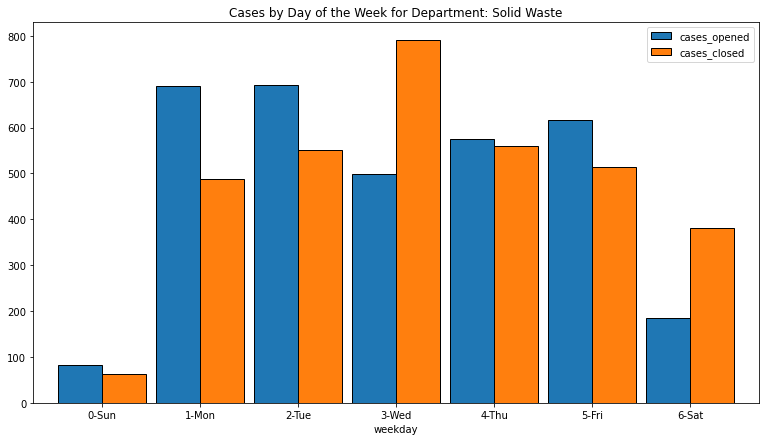

In [45]:
ts_SW['weekday'] = ts_SW.index.strftime('%w-%a')
ts_SW.groupby('weekday').mean().plot.bar(figsize=(13, 7), ec='black', width=.9)
plt.xticks(rotation=0)
plt.title('Cases by Day of the Week for Department: Solid Waste' )